# Машинное обучение
## Домашнее задание №1: KNN + Линейные модели

**Срок сдачи:** 30 ноября 2021, 08:30 

**Максимально баллов:** 10 

**Штраф за опоздание:** по 2 балла за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла. Формат сдачи будет указан чуть позже.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 баллов

При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность.

## KNN (5 баллов)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
#from sklearn.datasets import fetch_mldata, fetch_20newsgroups # у вас тут какое-то старье https://github.com/ageron/handson-ml/issues/529
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, make_scorer, pairwise_distances

from tqdm import tqdm

C:\Users\Elf\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Elf\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\Elf\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [3]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm        
        self.metric = metric
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X, metric = self.metric)
        if self.algorithm == 'kd_tree_spacial':
            self.tree = scipy.spatial.KDTree(X, balanced_tree = False)
    
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        if self.algorithm == 'brute':
            # считаем расстояния
            if self.metric == 'euclidean':
                dist_matrix = np.linalg.norm(X[:, None, :] - self.X[None, :, :], axis=-1)
            else:
                dist_matrix = pairwise_distances(X, metric = self.metric)
            # ищем индексы k ближних соседей
            neighbors_labels = np.argsort(dist_matrix, axis=1)[:, :self.n_neighbors]
            # смотрим популярный класс у ближних соседей
            for i, n in enumerate(np.take(self.y, neighbors_labels)): # идем по лейблам
                #counts = np.bincount(n) # считаем у каждого количество
                labels, counts = np.unique(n, return_counts=True)
                if np.max(counts) == 1:
                    pred[i] = labels[0]
                else:
                    pred[i] = labels[np.argwhere(counts == np.max(counts))[-1][0]] # берем самый популярный
                    
        if self.algorithm == 'kd_tree' or self.algorithm == 'kd_tree_spacial':
            _, nearest_ind = self.tree.query(X, k=self.n_neighbors)  # берем k ближайших
            for i, n in enumerate(np.take(self.y, nearest_ind.squeeze())): # идем по лейблам
                #counts = np.bincount(n) # считаем у каждого количество
                labels, counts = np.unique(n, return_counts=True)
                if np.max(counts) == 1:
                    pred[i] = labels[0]
                else:
                    pred[i] = labels[np.argwhere(counts == np.max(counts))[-1][0]] # берем самый популярный

        return pred

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%timeit clf.fit(X_train, y_train)

272 µs ± 52.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%timeit my_clf.fit(X_train, y_train)

692 ns ± 90.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [11]:
%timeit clf.predict(X_test)

4.72 ms ± 534 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit my_clf.predict(X_test)

1.01 ms ± 79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%timeit clf.fit(X_train, y_train)

396 µs ± 34.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit my_clf.fit(X_train, y_train)

121 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit clf.predict(X_test)

1.04 ms ± 44.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%timeit my_clf.predict(X_test)

915 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [43]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [44]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# чтобы уместить все в озу, надо вводить огранчиения
vectorizer = CountVectorizer(max_features=100)
X_vec = vectorizer.fit_transform(data).toarray()

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [23]:
from sklearn.model_selection import cross_validate, cross_val_score

In [24]:
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf.fit(X_vec, target)

In [25]:
cv_results = cross_val_score(my_clf, X_vec, target, cv=3, scoring=make_scorer(accuracy_score))

In [26]:
cv_results

array([0.126193  , 0.12516574, 0.12702201])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [27]:
mean_score = []
for n in tqdm(range(1, 10)):
    my_clf.n_neighbors = n
    cv_results = cross_val_score(my_clf, X_vec, target, cv=3, scoring=make_scorer(accuracy_score))
    mean_score.append(np.mean(cv_results))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:00<00:00, 13.40s/it]


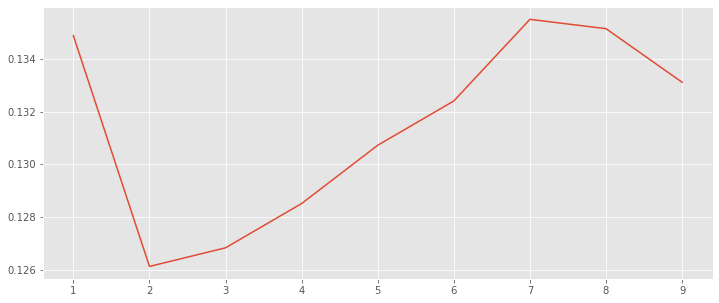

In [28]:
plt.plot(range(1, 10), mean_score)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

## Cosine metric

In [29]:
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute', metric='cosine')
my_clf.fit(X_vec, target)

mean_score = []
for n in tqdm(range(1, 10)):
    my_clf.n_neighbors = n
    cv_results = cross_val_score(my_clf, X_vec, target, cv=3, scoring=make_scorer(accuracy_score))
    mean_score.append(np.mean(cv_results))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:32<00:00,  3.64s/it]


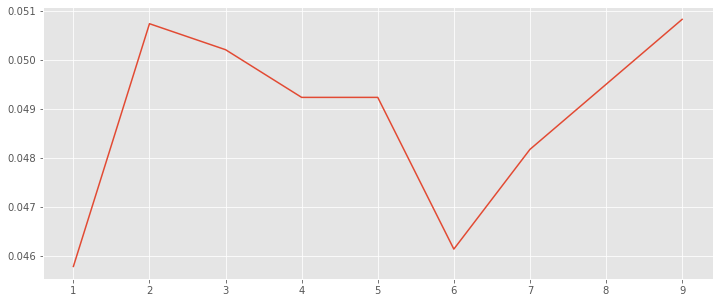

In [30]:
plt.plot(range(1, 10), mean_score)

## tf-idf

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_vec = tfidf_vectorizer.fit_transform(data).toarray()

In [32]:
my_clf_tfidf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf_tfidf.fit(X_vec, target)

In [33]:
mean_score = []
for n in tqdm(range(1, 10)):
    my_clf_tfidf.n_neighbors = n
    cv_results = cross_val_score(my_clf_tfidf, X_vec, target, cv=3, scoring=make_scorer(accuracy_score))
    mean_score.append(np.mean(cv_results))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:48<00:00, 18.70s/it]


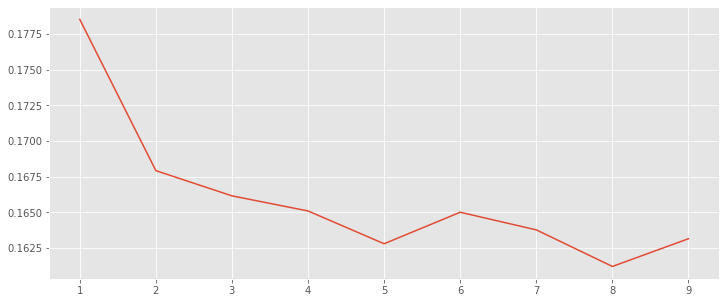

In [34]:
plt.plot(range(1, 10), mean_score)

## Tf-Idf + cosine

In [39]:
my_clf_tfidf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute', metric='cosine')
my_clf_tfidf.fit(X_vec, target)


mean_score = []
for n in tqdm(range(1, 10)):
    my_clf_tfidf.n_neighbors = n
    cv_results = cross_val_score(my_clf_tfidf, X_vec, target, cv=3, scoring=make_scorer(accuracy_score))
    mean_score.append(np.mean(cv_results))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:37<00:00,  4.15s/it]


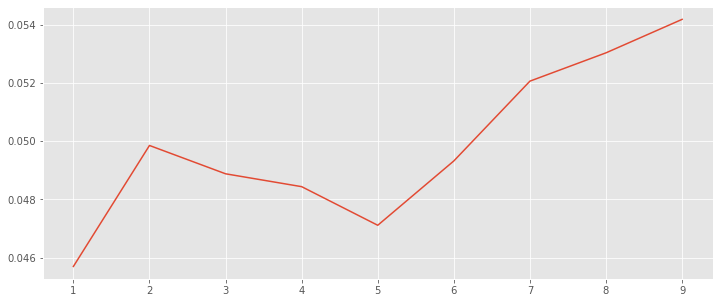

In [40]:
plt.plot(range(1, 10), mean_score)

Кажется лидер следующий

In [46]:
knn_optimal = MyKNeighborsClassifier(n_neighbors=1, algorithm='kd_tree')
knn_optimal.fit(X_vec, target)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [47]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [48]:
tfidf_vectorizer = TfidfVectorizer(max_features=100)

y_test = newsgroups['target']
X_test = tfidf_vectorizer.fit_transform(newsgroups['data']).toarray()

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [49]:
y_pred = knn_optimal.predict(X_test)
accuracy_score(y_test, y_pred)

0.0768720127456187

O_o\
Текст в прицнипе нетривиальная для анализа вещь, а анализировать его knn-ом дело тем более неблагодарное. Во-первых расстояние между текстами можно строить разными методами, во-вторых фичи из текста можно выделять множеством способов. knn при этом никак не учитывает смысл текста и полагается лишь на его векторное представление. Как результат, любое новое слово может как-то хитро вписать наш текст в пространтсво в плане расстояний

# Линейные модели (5 баллов)

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

### Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. 

Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [51]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    # Перемешаем индексы
    if len(y) % batch_size == 0:
        n_parts = len(y) // batch_size
    else:
        n_parts = len(y) // batch_size + 1
    batch_ind = np.array_split(np.random.permutation(len(y)), n_parts)
    
    for i in batch_ind:
        X_batch = X[i]
        y_batch = y[i]
        yield (X_batch, y_batch)

In [52]:
# Теперь можно сделать генератор по данным ()
# my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [54]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    ## Your code Here
    return 1 / (1 + np.exp(-x))


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        pred = self.predict(X_batch)
        
        if self.model_type == 'lin_reg':
            total_loss = np.inner(y_batch - pred, y_batch - pred) / len(X_batch) + 1 / self.C * np.inner(self.weights, self.weights)
        if self.model_type == 'log_reg':
            pred_loss = np.sum(y_batch * np.log(pred) + (1 - y_batch) * np.log(1 - pred))
            total_loss = - pred_loss / len(X_batch) + 1 / self.C * np.inner(self.weights, self.weights)
        
        return total_loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        if self.model_type == 'lin_reg':
            #print(np.transpose(X_batch).shape, y_batch.shape, (X_batch @ self.weights).shape, self.weights.shape)
            loss_grad = - 2 / len(X_batch) * np.transpose(X_batch) @ (y_batch - X_batch @ self.weights)  + 2 / self.C * self.weights
        if self.model_type == 'log_reg':
            loss_grad = - (y_batch - self.predict(X_batch)) @ X_batch / len(X_batch) + 2 / self.C * self.weights
            
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad
        # print(f"new weights : {self.weights}")
    
    def fit(self, X, y, n_step_mean = None):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        if n_step_mean is not None:
            plot_loss = []
            loss_mean = []
            counter = 0
        # Нужно инициализровать случайно веса
        self.weights = np.random.randn(X.shape[1]) * np.sqrt(2 / X.shape[1])
        for n in tqdm(range(0, self.max_epoch)):
            new_epoch_generator = self.batch_generator()
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
                if n_step_mean is not None:
                    if counter == n_step_mean:
                        counter = 0
                        plot_loss.append(np.mean(loss_mean))
                        loss_mean = []
                    else:
                        counter += 1
                        loss_mean.append(batch_loss)
        
        if n_step_mean is not None:
            return self, plot_loss
        else:
            return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        if self.model_type == 'lin_reg':
            y_hat = X @ self.weights
        if self.model_type == 'log_reg':
            y_hat = sigmoid(X @ self.weights)
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [55]:
def plot_decision_boundary(clf, x):
    ## Your code Here
    y = -clf.weights[0] / clf.weights[1] * x
    return y

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.85it/s]


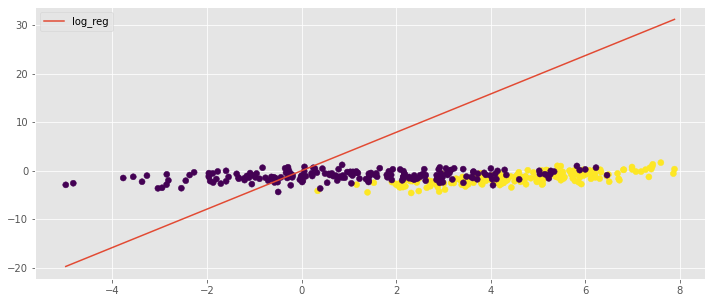

In [56]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

generator = lambda: batch_generator(X, y, shuffle=True, batch_size=1)

my_lin_reg = MySGDClassifier(generator, model_type='lin_reg')
my_log_reg = MySGDClassifier(generator, model_type='log_reg')

my_lin_reg.fit(X, y)
my_log_reg.fit(X, y)

X_plot = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
lin_reg_line = plot_decision_boundary(my_lin_reg, X_plot)
log_reg_line = plot_decision_boundary(my_log_reg, X_plot)

plt.scatter(X[:,0], X[:,1], c=y)
#plt.plot(X_plot, lin_reg_line, label='lin_reg')
plt.plot(X_plot, log_reg_line, label='log_reg')
plt.legend()
plt.show()

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [57]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [58]:
## Your Code Here
generator_2 = lambda: batch_generator(X, y, shuffle=True, batch_size=1)

lin_reg_2 = MySGDClassifier(generator_2, model_type='lin_reg')
log_reg_2 = MySGDClassifier(generator_2, model_type='log_reg')

alphas_arr = [0.01, 5e-3, 1e-3, 1e-4, 1e-5]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.06s/it]


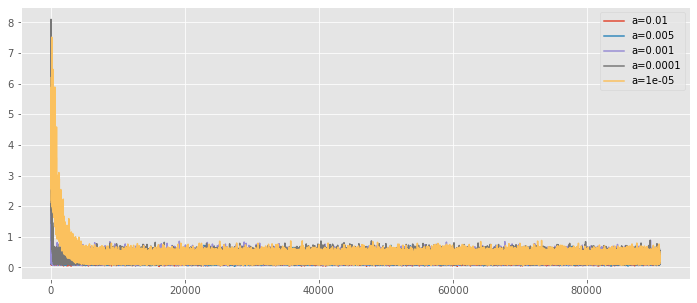

In [59]:
for alpha in alphas_arr:
    lin_reg_2.alpha = alpha
    _, plot_loss = lin_reg_2.fit(X, y, n_step_mean = 10)
    plt.plot(plot_loss, label=f"a={alpha}")
plt.legend()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.40s/it]


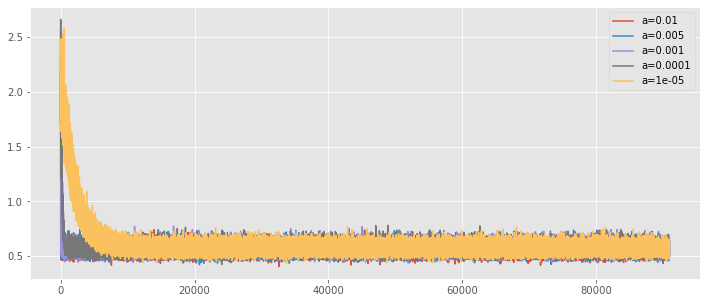

In [60]:
for alpha in alphas_arr:
    log_reg_2.alpha = alpha
    _, plot_loss = log_reg_2.fit(X, y, n_step_mean = 10)
    plt.plot(plot_loss, label=f"a={alpha}")
plt.legend()
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?\
**Ответ:** Шаг точно не должен быть больше 0.01. Похоже, что оптимально что-то между 0.01 и 0.005

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [61]:
lin_reg_2 = MySGDClassifier(generator_2, model_type='lin_reg', alpha=0.005)
log_reg_2 = MySGDClassifier(generator_2, model_type='log_reg', alpha=0.005)
c_arr = np.logspace(3, -3, 10)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]<ipython-input-54-d698720a24c4>:42: RuntimeWarning: overflow encountered in double_scalars
  total_loss = np.inner(y_batch - pred, y_batch - pred) / len(X_batch) + 1 / self.C * np.inner(self.weights, self.weights)
<ipython-input-54-d698720a24c4>:59: RuntimeWarning: overflow encountered in multiply
  loss_grad = - 2 / len(X_batch) * np.transpose(X_batch) @ (y_batch - X_batch @ self.weights)  + 2 / self.C * self.weights
<ipython-input-54-d698720a24c4>:70: RuntimeWarning: invalid value encountered in subtract
  self.weights -= self.alpha * new_grad
  0%|                                                                                           | 0/10 [00:00<?, ?it/s]<ipython-input-54-d698720a24c4>:120: RuntimeWarning: invalid value encountered in matmul
  y_hat = X @ self.weights
<ipython-input-54-d698720a24c4>:59: RuntimeWarning: invalid value encountered in add
  loss_gr

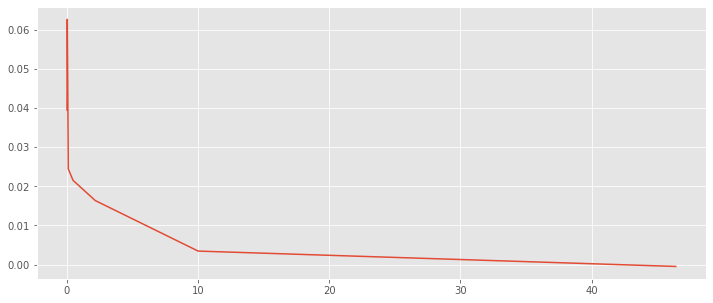

In [65]:
## Your Code Here
weight_mean = []

for c in c_arr:
    lin_reg_2.C = c
    lin_reg_2.fit(X, y)
    weight_mean.append(np.mean(lin_reg_2.weights))

plt.plot(1 / c_arr, weight_mean)
plt.show()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]<ipython-input-54-d698720a24c4>:44: RuntimeWarning: divide by zero encountered in log
  pred_loss = np.sum(y_batch * np.log(pred) + (1 - y_batch) * np.log(1 - pred))
<ipython-input-54-d698720a24c4>:44: RuntimeWarning: invalid value encountered in multiply
  pred_loss = np.sum(y_batch * np.log(pred) + (1 - y_batch) * np.log(1 - pred))
<ipython-input-54-d698720a24c4>:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-54-d698720a24c4>:45: RuntimeWarning: overflow encountered in double_scalars
  total_loss = - pred_loss / len(X_batch) + 1 / self.C * np.inner(self.weights, self.weights)
<ipython-input-54-d698720a24c4>:61: RuntimeWarning: overflow encountered in multiply
  loss_grad = - (y_batch - self.predict(X_batch)) @ X_batch / len(X_batch) + 2 / self.C * self.weights
<ipython-input-54-d698720a24c4>:70: RuntimeWarning: invalid val

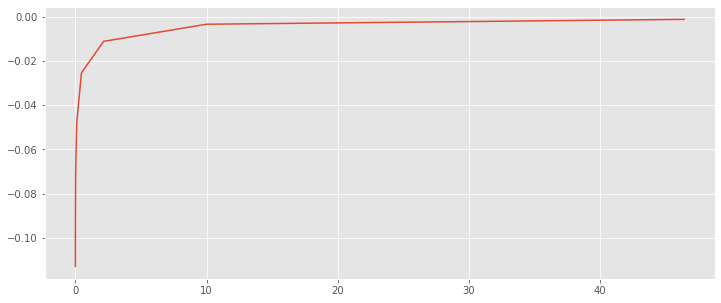

In [66]:
## Your Code Here
weight_mean = []

for c in c_arr:
    log_reg_2.C = c
    log_reg_2.fit(X, y)
    weight_mean.append(np.mean(log_reg_2.weights))
    
plt.plot(1 / c_arr, weight_mean)
plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

Веса действительно уменшились значительно. Регуляризация исправно работает